In [1]:
from collections import OrderedDict
from pathlib import Path
import multiprocessing
import contextlib

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.spatial.distance import hamming
from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def print_alignment(seq1, seq2):
    alignment = pairwise2.align.globalxx(seq1, seq2)
    print(pairwise2.format_alignment(*alignment[0]))
    

data_path = Path('../data/Protera')
!ls $data_path

clustering   data.csv  mmseq_q	prefilter.out  search	   sequences.fasta  tmp
cluster.out  mmseq     mmseq_t	prism	       search.out  stability.csv


In [2]:
data = pd.read_csv(data_path / "stability.csv")

## Data Duplication

In [3]:
len(data['sequences'].unique()) == len(data), data['sequences'].unique().shape, len(data)

(False, (142443,), 583851)

In [4]:
data = data.drop_duplicates()
data

,sequences,labels
0,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.226782
1,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.782184
2,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,1.151609
3,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.292759
4,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,-0.880000
...,...,...
202934,HKLRKLNPPDESGPGCMSCKCVLSSMTEYKLVVVGAGGVGKSALTI...,0.405517
202935,HKLRKLNPPDESGPGCMSCKCVLSTMTEYKLVVVGAGGVGKSALTI...,0.173793
202936,HKLRKLNPPDESGPGCMSCKCVLSVMTEYKLVVVGAGGVGKSALTI...,2.447356
202937,HKLRKLNPPDESGPGCMSCKCVLSWMTEYKLVVVGAGGVGKSALTI...,1.032299


## Alignments

In [5]:
# %timeit pairwise2.align.localmx(data['sequences'][0], data['sequences'][1], 1, 0)

In [6]:
# %timeit pairwise2.align.globalxx(data['sequences'][0], data['sequences'][1])

## Score per metrics

* More unique values => more stability?
* Does sequence length matter?


In [7]:
def append_to_key(d, k, v):
    if k in d:
        values = d[k]
        values.append(v)
        d[k] = values
        
    else:
        d[k] = [v]
        
def compute_mean_scores(d):
    new_d = dict()
    for k in d:
        mean_score = np.mean(d[k])
        new_d[k] = (mean_score, len(d[k]))
        
    return  OrderedDict(sorted(new_d.items()))

score_per_length = dict()
score_per_uniqueness = dict()

for idx, (seq, score) in data.iterrows():
    # score_per_length
    size = len(seq)
    append_to_key(score_per_length, size, score)
    
    
    # score_per_uniqueness => score per number of unique aminoacids in each seq
    uniques = set(seq)
    unique_size = len(uniques)
    
    append_to_key(score_per_uniqueness, unique_size, score)
    
    # count unique aminoacids
    for amino in uniques:
        uniques.add(amino)

In [8]:
compute_mean_scores(score_per_length)

OrderedDict([(67, (0.9057751840957926, 1102)),
             (74, (1.4451812751889404, 1349)),
             (77, (1.1445754647569504, 2812)),
             (103, (1.286925200436685, 3306)),
             (151, (1.1443029242667568, 2641)),
             (161, (1.634530384824353, 2983)),
             (166, (1.5775506460669793, 2964)),
             (179, (1.4971539885887808, 2907)),
             (191, (1.7890972966275298, 3154)),
             (233, (1.3742664851784707, 4332)),
             (245, (1.9083088648345037, 4256)),
             (247, (1.7661625151570426, 4351)),
             (252, (1.80805768275468, 4674)),
             (288, (1.9360205176701843, 4959)),
             (305, (0.9972862768821978, 1938)),
             (310, (1.4987711794857383, 2451)),
             (332, (2.2146651533399533, 6213)),
             (362, (1.7637988821771322, 6365)),
             (395, (1.6426984590222728, 3781)),
             (405, (1.758458296139091, 5833)),
             (415, (1.2377106719544715, 4104)),


In [9]:
compute_mean_scores(score_per_uniqueness)

OrderedDict([(17, (1.2191776852283291, 2368)),
             (18, (1.1524984137931022, 5000)),
             (19, (1.4371670347157923, 11246)),
             (20, (1.7104500806976233, 118927)),
             (21, (1.79797436654989, 4902))])

## By Score

In [10]:
sorted_train = data.sort_values(by='labels')
sorted_train = sorted_train.reset_index(drop = True)

In [11]:
print_alignment(sorted_train['sequences'][0], sorted_train['sequences'][1])
sorted_train.head(5)

PDFRIAFQELLCLRRSSLK-AYGNG-YSSNGNTGEQSGYHVEQEKENKLLCEDLPGT--EDF-VG-HQGTVPS-DNIDSQGRNC-STNDSLL--WMGQPGNGSAFLLAPNG-SHAPDH--DVTQE---RDEVWVV-----GMGIVMSLIVLAIVF--GNVLVITAIAKFERLQTVTNYFITSLACAD-LVMGLAVVPFG-------AAHILMKMWT--FGNFWC-EFWTSI-DVLCVTASIETLCVIAVDRYFAITSPFKYQ----SL--LTK-NKARVIILMVWIVSGLT-S--FLPIQMHWYRATHQE-AINCYANETCCDFFTN-QAYAI-ASSIVSFYVP--LVIMVFV--YSRVFQEAKRQLQKID-KSEGRFHV-QNL--SQVEQ----DGRTGHGLRRS--SKFCLK-EHKALKTL---GIIMGTF-TLCW-LPFFIVNIVHVIQDNLIR-K-EVYILL-NWI--G-YVNSGFNPLIYCRS--------P
|    |              |     |     |              |     | |   |   |  |       | ||       ||       ||          |     |       ||||    |           | |   |          |    |  |    |         |   |   |  |    |         ||  |       ||     ||     |   | |   |        |    |    |    |   |   |      |       |  |  |  |      |     |    |       |   |     |   |   |   |        |  |       |     |    |   |    |  |     |      |     |      ||         | |     |    |          |  ||   | |      |    | ||       ||           |
P---

,sequences,labels
0,PDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENK...,-6.076782
1,PAVALYTKLGIREEVMHFDIDPSTATWMLRSSNDVTQQGSRPKTKL...,-5.827586
2,TELTTKGRVPYPGMVNREXLDQVERGYRMPCPPECPEXLHDLMCQC...,-5.286897
3,PLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPG...,-5.237471
4,PDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENK...,-4.742644


In [12]:
print_alignment(sorted_train['sequences'][len(sorted_train)-1], sorted_train['sequences'][len(sorted_train)-2])
sorted_train.tail(5)

GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQIQYHSTGKSSQRQMVFGVVTAIDLLNFVAAQERDQKW-MPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKEPLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

,sequences,labels
142438,GCRAIGLGGGASSRVLADGMTRGPVVRLPRACDSAEVKAWLETSEG...,45.396552
142439,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,46.291724
142440,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,52.328276
142441,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,54.201034
142442,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,82.530115


## Subsampling techniques

* Diversity Maximizing: This is a greedy strategy which starts from the reference and adds the sequence with highest average hamming distance to current set of sequences.

* Diversity Minimizing: This strategy is equivalent to the Diversity Maximizing strategy, but adds the se- quence with lowest average hamming distance. It is used to explore the effects of diversity on model per- formance.

* HHFilter: This strategy applies hhfilter (Steinegger etal.,2019)withthe-diff Mparameter,whichre- turns M or more sequences that maximize diversity (the result is usually close to M). If more than M sequences are returned we apply the Diversity Maxi- mizing strategy on top of the output.

In [13]:
def compute_diversity(seq1, seq2, method="hamming"):
    if method == "alignment":
        method = pairwise2.align.globalxx
        diversity = method(seq1, seq2)
        diversity = diversity[0].score / max(len(seq1), len(seq2))

    elif method == "hamming":
        if len(seq1) != len(seq2):
            size = min(len(seq1), len(seq2))
            seq1 = seq1[:size]
            seq2 = seq2[:size]

        method = hamming
        # print(list(seq1), "\n" ,list(seq2))
        diversity = method(list(seq1), list(seq2))

    return diversity


def div_vs_all(sequence, other_sequences, method="hamming", reducer=np.nanmean):
    v_diversity = np.vectorize(lambda x: compute_diversity(sequence, x, method=method))
    if len(other_sequences) > 1:
        div_vs_all = v_diversity(other_sequences)
    else:
        print(f"Skipping {sequence}")
        return np.nan

    reduced_div_vs_all = reducer(div_vs_all) if len(div_vs_all) >= 1 else np.nan
    return reduced_div_vs_all


def dataset_diversity(sequences, method="hamming", reduce="mean", verbose=True):
    if reduce != "mean":
        raise NotImplementedError
    else:
        # nan results are due to different lengths
        reducer = np.nanmean

    reduced_divs = []
    if verbose:
        pbar = tqdm(total=len(sequences), miniters=1, smoothing=1)

    all_other_sequences = [
        np.concatenate((sequences[:idx], sequences[idx + 1 :]))
        for idx in range(len(sequences))
    ]

    with contextlib.closing(multiprocessing.Pool(4)) as pool:
        for sequence_idx, sequence in enumerate(sequences):
            other_sequences = all_other_sequences[sequence_idx]
            reduced_divs.append(
                pool.apply_async(div_vs_all, args=(sequence, other_sequences, method))
            )

    for idx, result in enumerate(reduced_divs):
        reduced_divs[idx] = result.get()
        if verbose:
            pbar.update(1)
            pbar.refresh()

    pool.join()

    if verbose:
        pbar.close()

    return reduced_divs


def get_cluster_diversity():
    rep_seqs = dict()
    rep_seq_glob = list((data_path / "clustering").glob("cluster_*_rep_seq.fasta"))
    print(rep_seq_glob)

    for rep_seqs_pth in rep_seq_glob:
        df_name = rep_seqs_pth.stem.split("_")[1]

        df = pd.DataFrame()

        sequences = [str(record.seq) for record in SeqIO.parse(rep_seqs_pth, "fasta")]
        sequences = np.random.choice(sequences, 3000)
        alignment = dataset_diversity(sequences, "alignment")
        hamming = dataset_diversity(sequences, "hamming")

        df["sequences"] = sequences
        df["alignment"] = alignment
        df["hamming"] = hamming

        rep_seqs[df_name] = df

    return rep_seqs

In [14]:
diversity_alignment = compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "alignment",
)

diversity_hamming = compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "hamming"
)

diversity_alignment, diversity_hamming,  data["sequences"].values[0],  data["sequences"].values[11]

(0.987012987012987,
 0.012987012987012988,
 'QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGAQ',
 'QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGNQ')

In [15]:
#diversities = dataset_diversity(np.random.choice(data["sequences"].values, 14245))

In [16]:
records = []
for row_idx, row in tqdm(data.iterrows(), total=len(data)):
    record = SeqRecord(
        Seq(row.sequences),
        id=str(row[0]),
        name=f"mutagenesis_{row_idx}",
        description="",
        annotations={"labels": row.labels}
    )
    records.append(record)
    if len(row.sequences) > 6000: print(row_idx)
    
# SeqIO.write(records, data_path / "sequences.fasta", "fasta")

100%|██████████| 142443/142443 [00:14<00:00, 9552.09it/s] 


In [25]:
!ls $data_path/clustering

0.3.csv			    cluster_0.5_all_seqs.fasta
0.5.csv			    cluster_0.5_cluster.tsv
0.7.csv			    cluster_0.5_rep_seq.fasta
cluster_0.3_all_seqs.fasta  cluster_0.7_all_seqs.fasta
cluster_0.3_cluster.tsv     cluster_0.7_cluster.tsv
cluster_0.3_rep_seq.fasta   cluster_0.7_rep_seq.fasta


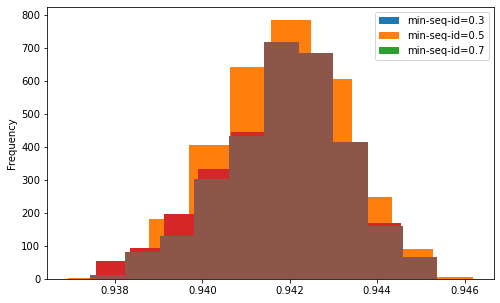

In [35]:
rep_seqs_diversity = {
    "0.3": pd.read_csv(data_path/"clustering"/"0.3.csv"),
    "0.5": pd.read_csv(data_path/"clustering"/"0.5.csv"),
    "0.7": pd.read_csv(data_path/"clustering"/"0.7.csv")
}

f, axs = plt.subplots(ncols=1, figsize=(8,5))

for min_id, df in rep_seqs_diversity.items():
    df.plot.hist(by="hamming", ax=axs)

# for min_id, df in rep_seqs_diversity.items():
#     df.plot.hist(by="alignment", ax=axs[1])

axs.legend([f"min-seq-id={min_idty}" for min_idty in rep_seqs_diversity.keys()]);
# axs[1].legend([f"min-seq-id={min_idty}" for min_idty in rep_seqs_diversity.keys()]);

In [19]:
# ds_div_train = dataset_diversity(sets["train"]["sequence"])
# sets["train"]["diversity"] = np.nanmean(np.array(ds_div_train), 1)
# np.nanmean(np.array(ds_div_train))
# 0.8xxx

In [20]:
# ds_div_test = dataset_diversity(sets["test"]["sequence"])
# sets["test"]["diversity"] = np.nanmean(np.array(ds_div_test), 1)
# np.nanmean(np.array(ds_div_test))

In [21]:
# sets["train"].to_csv(f"{data_path}/stability_diversity_train.csv")
# sets["test"].to_csv(f"{data_path}/stability_diversity_test.csv")

In [22]:
import numpy as np

def onehot_pair(u, v):
    vocab = set(u).union(set(v))
    mapping = {k: v for v, k in enumerate(vocab)}
    
    for idx, val in enumerate(u):
        u[idx] = mapping[val]
    
    for idx, val in enumerate(v):
        v[idx] = mapping[val]
        
    return u, v

def onehot_arrays(arrays):
    vocab = set()
    for array in arrays[1:]:
        vocab = vocab.union(set([char for char in array]))
    
    mapping = {k: v for v, k in enumerate(vocab)}
    
    array_final = np.empty_like(arrays)
    for idx, string in enumerate(arrays):
        array = np.array([char for char in string])
        for arr_idx, val in enumerate(array):
            array[arr_idx] = mapping[val]
        array_final[idx] = array
        
    return array_final

def _validate_vector(u, dtype=None):
    u = np.asarray(u, dtype=dtype)
    if u.ndim == 1:
        return u

    # Ensure values such as u=1 and u=[1] still return 1-D arrays.
    u = np.atleast_1d(u.squeeze())
    if u.ndim > 1:
        raise ValueError("Input vector should be 1-D.")
    warnings.warn(
        "scipy.spatial.distance metrics ignoring length-1 dimensions is "
        "deprecated in SciPy 1.7 and will raise an error in SciPy 1.9.",
        DeprecationWarning)
    return u

def hamming(u, v):
    if np.array(u).dtype == "<U1" and np.array(v).dtype == "<U1":
        u, v = onehot_pair(u, v)
    u = _validate_vector(u)
    v = _validate_vector(v)
        
    u_ne_v = u != v
    
    return np.average(u_ne_v)